# Data cleaning

Scripts to build and clean CFD data

In [217]:
# modules
import pandas as pd
import os
import geopandas as gpd
import json
import requests
import shapely
import datetime

In [218]:
# directories
data_dir = os.path.join('..', 'data')
raw_dir = os.path.join(data_dir, 'raw')
clean_dir = os.path.join(data_dir, 'clean')

In [219]:
# links to Charlottesville Open Data portal
baseurl = 'https://opendata.arcgis.com/datasets/'
parcel_area_url = '320d465ddf0d498796da6491e21f6dde_43.geojson'
parcel_area_detail_url = '0e9946c2a77d4fc6ad16d9968509c588_72.geojson'

## Get parcel data

The first step is to get parcel data, base and details, and merge them together

In [220]:
# get parcel data
df = requests.get(baseurl + parcel_area_url).json()

# convert to spatial dataframe
df = gpd.GeoDataFrame.from_features(df)

# add CRS so we can map
df.crs = {'init' :'epsg:4326'}

# lower column names
df.columns = map(str.lower, df.columns)

In [221]:
df.head()

,gpin,objectid,shapestarea,shapestlength,geometry
0,3,1,23226.875,633.226985,"POLYGON ((-78.4715397102249 38.0702628731315, ..."
1,5,2,16439.625,560.043766,"POLYGON ((-78.47202942120795 38.0704016593016,..."
2,6,3,14890.250,526.157128,POLYGON ((-78.47128624748304 38.06999645529831...
3,8,4,18389.375,568.351854,POLYGON ((-78.47244282098968 38.07025827952778...
4,10,5,17774.500,564.087227,POLYGON ((-78.47285274869012 38.07010665967572...


In [222]:
# get parcel data
df_detail = requests.get(baseurl + parcel_area_detail_url).json()

# convert to spatial dataframe
df_detail = gpd.GeoDataFrame.from_features(df_detail)

# lower column names
df_detail.columns = map(str.lower, df_detail.columns)

# drop geometry
df_detail.drop(['geometry','objectid'], axis=1,inplace=True)

In [223]:
df = df.merge(df_detail, on='gpin', how='left')

In [224]:
df.head()

,gpin,objectid,shapestarea,shapestlength,geometry,assessment,filetype,legaldescr,lotsqft,mappage,pin,taxyear,zone,st_name,st_number,st_unit
0,3,1,23226.875,633.226985,"POLYGON ((-78.4715397102249 38.0702628731315, ...",400800,R,LOT 63A&PAR X-11 GREENBRIER HG,22172.04,42C,42C104000,2018 Value:,R-1,GLENN CT,2313,
1,5,2,16439.625,560.043766,"POLYGON ((-78.47202942120795 38.0704016593016,...",344300,R,LOT 62A-1&PAR X-10 GREENBRIER,16857.72,42C,42C105000,2018 Value:,R-1,GLENN CT,2315,
2,6,3,14890.250,526.157128,POLYGON ((-78.47128624748304 38.06999645529831...,434200,R,LOT 64A BK C GREENBRIER HGTS,14679.72,42C,42C103000,2018 Value:,R-1,GLENN CT,2311,
3,8,4,18389.375,568.351854,POLYGON ((-78.47244282098968 38.07025827952778...,395800,R,LOT 61A-1&PAR X-9 GREENBRIER H,17336.88,42C,42C106000,2018 Value:,R-1,GLENN CT,2317,
4,10,5,17774.500,564.087227,POLYGON ((-78.47285274869012 38.07010665967572...,423400,R,LOT 60&PAR X-8 GREENBRIER HGTS,16857.72,42C,42C107000,2018 Value:,R-1,GLENN CT,2319,


## Get fire incident data

Get fire incident data and convert to GeoDataFrame.

In [225]:
# read in fire incidents
fire = pd.read_csv(os.path.join(raw_dir, '12_16to5_18FireResponses-cleaner.csv'))
fire.size

4634

In [226]:
# remove empty lon/lat
fire.dropna(subset=['basic_incident_longitude_fd1_69','basic_incident_latitude_fd1_69'], inplace=True)
fire.size

4550

In [227]:
# make coordinates
fire['coordinates'] = list(zip(fire.basic_incident_longitude_fd1_69, fire.basic_incident_latitude_fd1_69))
fire['coordinates'] = fire['coordinates'].apply(shapely.geometry.Point)

# make geodataframe
fire = gpd.GeoDataFrame(fire, geometry='coordinates')
fire.crs = {'init' :'epsg:4326'}

In [228]:
# convert to datetime
def to_date(dt_str):
    dt_str = str(dt_str)
    if (dt_str == 'nan'):
        return pd.NaT
    else:
        return datetime.datetime.strptime(str(dt_str), '%Y-%m-%dT%H:%M:%SZ')

fire['dt'] = pd.to_datetime(fire['apparatus_resource_dispatch_date_time_fd18_3'], format='%Y-%m-%dT%H:%M:%SZ')

In [229]:
fire

,basic_incident_number_fd1,basic_incident_date_original_fd1_3,basic_incident_latitude_fd1_69,basic_incident_longitude_fd1_69,basic_incident_type_fd1_21,basic_incident_type_code_and_description_fd1_21,basic_incident_type_subcategory_fd1_21,basic_incident_type_category_fd1_21,apparatus_resource_dispatch_date_time_fd18_3,basic_incident_psap_to_alarm_in_minutes,apparatus_resource_dispatch_to_en_route_in_minutes,apparatus_resource_en_route_to_arrived_in_minutes,apparatus_resource_vehicle_call_sign_list,apparatus_resource_arrival_date_time_fd18_4,coordinates,dt
0,2016-00006495,2016-12-20,38.042275,-78.500969,"Special outside fire, other","160 - Special outside fire, other",16 - Special outside fire,1 - Fire,2016-12-20T08:43:00Z,2.50,NaN,NaN,",,,,,",NaN,POINT (-78.500969 38.042275),2016-12-20 08:43:00
1,2016-00006520,2016-12-20,38.009043,-78.506330,Brush or brush-and-grass mixture fire,142 - Brush or brush-and-grass mixture fire,14 - Natural vegetation fire,1 - Fire,2016-12-20T23:08:00Z,2.62,NaN,NaN,NaN,2016-12-20T23:13:00Z,POINT (-78.50633000000001 38.009043),2016-12-20 23:08:00
2,2016-00006545,2016-12-21,38.020890,-78.486643,Brush or brush-and-grass mixture fire,142 - Brush or brush-and-grass mixture fire,14 - Natural vegetation fire,1 - Fire,2016-12-21T21:25:00Z,1.03,0.05,2.55,",",2016-12-21T21:28:00Z,POINT (-78.486643 38.02089),2016-12-21 21:25:00
3,2016-00006672,2016-12-26,38.023539,-78.487012,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2016-12-26T05:06:00Z,0.50,NaN,NaN,",,,,,,,,,,,,",NaN,POINT (-78.48701199999998 38.023539),2016-12-26 05:06:00
4,2017-00000106,2017-01-04,38.039550,-78.470475,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2017-01-05T04:10:00Z,1.08,0.58,NaN,",,FM3,,,,,,,,,,,,FM4,",NaN,POINT (-78.47047499999999 38.03955),2017-01-05 04:10:00
5,2017-00000189,2017-01-07,38.043244,-78.517575,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-07T20:06:00Z,0.73,0.03,NaN,",",NaN,POINT (-78.51757499999999 38.043244),2017-01-07 20:06:00
6,2017-00000245,2017-01-09,38.061426,-78.485375,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-09T08:38:00Z,1.50,1.83,4.87,",,,",2017-01-09T08:45:00Z,POINT (-78.485375 38.061426),2017-01-09 08:38:00
7,2017-00000367,2017-01-13,38.030561,-78.485999,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2017-01-13T15:19:00Z,3.22,0.52,1.18,",FM2,FM4,,,",2017-01-13T15:21:00Z,POINT (-78.48599899999999 38.030561),2017-01-13 15:19:00
8,2017-00000459,2017-01-15,38.026901,-78.462024,"Outside rubbish, trash or waste fire","151 - Outside rubbish, trash or waste fire",15 - Outside rubbish fire,1 - Fire,2017-01-16T00:14:00Z,1.20,1.53,NaN,",,,,,,,,",NaN,POINT (-78.462024 38.026901),2017-01-16 00:14:00
9,2017-00000460,2017-01-15,38.026260,-78.522415,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-16T00:27:00Z,1.57,0.90,NaN,",,,",NaN,POINT (-78.52241500000001 38.02626),2017-01-16 00:27:00


In [230]:
# split datetime to year month day hour minute
cols = ['year','month','day','hour','minute','second']
fire[cols] = pd.DataFrame([(x.year, x.month, x.day, x.hour, x.minute, x.second) for x in fire['dt']])

In [231]:
fire

,basic_incident_number_fd1,basic_incident_date_original_fd1_3,basic_incident_latitude_fd1_69,basic_incident_longitude_fd1_69,basic_incident_type_fd1_21,basic_incident_type_code_and_description_fd1_21,basic_incident_type_subcategory_fd1_21,basic_incident_type_category_fd1_21,apparatus_resource_dispatch_date_time_fd18_3,basic_incident_psap_to_alarm_in_minutes,...,apparatus_resource_vehicle_call_sign_list,apparatus_resource_arrival_date_time_fd18_4,coordinates,dt,year,month,day,hour,minute,second
0,2016-00006495,2016-12-20,38.042275,-78.500969,"Special outside fire, other","160 - Special outside fire, other",16 - Special outside fire,1 - Fire,2016-12-20T08:43:00Z,2.50,...,",,,,,",NaN,POINT (-78.500969 38.042275),2016-12-20 08:43:00,2016.0,12.0,20.0,8.0,43.0,0.0
1,2016-00006520,2016-12-20,38.009043,-78.506330,Brush or brush-and-grass mixture fire,142 - Brush or brush-and-grass mixture fire,14 - Natural vegetation fire,1 - Fire,2016-12-20T23:08:00Z,2.62,...,NaN,2016-12-20T23:13:00Z,POINT (-78.50633000000001 38.009043),2016-12-20 23:08:00,2016.0,12.0,20.0,23.0,8.0,0.0
2,2016-00006545,2016-12-21,38.020890,-78.486643,Brush or brush-and-grass mixture fire,142 - Brush or brush-and-grass mixture fire,14 - Natural vegetation fire,1 - Fire,2016-12-21T21:25:00Z,1.03,...,",",2016-12-21T21:28:00Z,POINT (-78.486643 38.02089),2016-12-21 21:25:00,2016.0,12.0,21.0,21.0,25.0,0.0
3,2016-00006672,2016-12-26,38.023539,-78.487012,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2016-12-26T05:06:00Z,0.50,...,",,,,,,,,,,,,",NaN,POINT (-78.48701199999998 38.023539),2016-12-26 05:06:00,2016.0,12.0,26.0,5.0,6.0,0.0
4,2017-00000106,2017-01-04,38.039550,-78.470475,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2017-01-05T04:10:00Z,1.08,...,",,FM3,,,,,,,,,,,,FM4,",NaN,POINT (-78.47047499999999 38.03955),2017-01-05 04:10:00,2017.0,1.0,5.0,4.0,10.0,0.0
5,2017-00000189,2017-01-07,38.043244,-78.517575,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-07T20:06:00Z,0.73,...,",",NaN,POINT (-78.51757499999999 38.043244),2017-01-07 20:06:00,2017.0,1.0,7.0,20.0,6.0,0.0
6,2017-00000245,2017-01-09,38.061426,-78.485375,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-09T08:38:00Z,1.50,...,",,,",2017-01-09T08:45:00Z,POINT (-78.485375 38.061426),2017-01-09 08:38:00,2017.0,1.0,9.0,8.0,38.0,0.0
7,2017-00000367,2017-01-13,38.030561,-78.485999,Building fire,111 - Building fire,11 - Structure Fire,1 - Fire,2017-01-13T15:19:00Z,3.22,...,",FM2,FM4,,,",2017-01-13T15:21:00Z,POINT (-78.48599899999999 38.030561),2017-01-13 15:19:00,2017.0,1.0,13.0,15.0,19.0,0.0
8,2017-00000459,2017-01-15,38.026901,-78.462024,"Outside rubbish, trash or waste fire","151 - Outside rubbish, trash or waste fire",15 - Outside rubbish fire,1 - Fire,2017-01-16T00:14:00Z,1.20,...,",,,,,,,,",NaN,POINT (-78.462024 38.026901),2017-01-16 00:14:00,2017.0,1.0,16.0,0.0,14.0,0.0
9,2017-00000460,2017-01-15,38.026260,-78.522415,"Cooking fire, confined to container","113 - Cooking fire, confined to container",11 - Structure Fire,1 - Fire,2017-01-16T00:27:00Z,1.57,...,",,,",NaN,POINT (-78.52241500000001 38.02626),2017-01-16 00:27:00,2017.0,1.0,16.0,0.0,27.0,0.0


## Join fire incidents to parcels using lon/lat in polygons

Rather than trying to fuzzy match on address, see how well we can find the fire incident points in the parcel polygons.

In [232]:
geo_p = df[['geometry', 'objectid']]
geo_f = fire[['coordinates','basic_incident_number_fd1']]

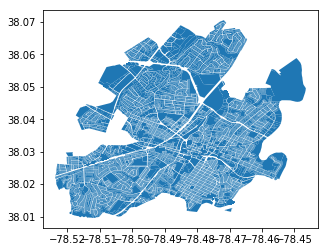

In [233]:
geo_p.plot()

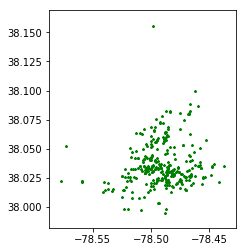

In [234]:
geo_f.plot(marker='*', color='green', markersize=5)

In [235]:
# limit fires to inside Charlottesville proper
# NB: doesn't include UVa or some fire incidents in Albemarle County
cville_fires = gpd.sjoin(geo_f, geo_p, how='inner')
cville_fires

,coordinates,basic_incident_number_fd1,index_right,objectid
2,POINT (-78.486643 38.02089),2016-00006545,13220,12048
22,POINT (-78.485878 38.022615),2017-00001006,13220,12048
88,POINT (-78.485671 38.023004),2017-00004095,13220,12048
114,POINT (-78.48656200000001 38.02144699999999),2017-00004996,13220,12048
168,POINT (-78.48590799999999 38.021622),2017-00007418,13220,12048
3,POINT (-78.48701199999998 38.023539),2016-00006672,9129,8027
6,POINT (-78.485375 38.061426),2017-00000245,15268,13535
8,POINT (-78.462024 38.026901),2017-00000459,8201,7116
10,POINT (-78.493996 38.032335),2017-00000478,14128,12561
11,POINT (-78.50331800000001 38.042526),2017-00000492,2845,2740


In [236]:
# drop geometry and convert to pandas data frame
cville_fires = pd.DataFrame(cville_fires.drop(columns=['coordinates','index_right']))

# add column of ones
cville_fires['fire'] = 1

# join back to parcel data frame
df = df.merge(cville_fires, how='left', on='objectid')

# fill fire NaNs with 0, b/c that's what they are
df['fire'].fillna(0, inplace=True)

# merge in other fire information
df = df.merge(fire, how='left', on='basic_incident_number_fd1')


In [237]:
df

,gpin,objectid,shapestarea,shapestlength,geometry,assessment,filetype,legaldescr,lotsqft,mappage,...,apparatus_resource_vehicle_call_sign_list,apparatus_resource_arrival_date_time_fd18_4,coordinates,dt,year,month,day,hour,minute,second
0,3,1,23226.875000,633.226985,"POLYGON ((-78.4715397102249 38.0702628731315, ...",400800,R,LOT 63A&PAR X-11 GREENBRIER HG,22172.04,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,5,2,16439.625000,560.043766,"POLYGON ((-78.47202942120795 38.0704016593016,...",344300,R,LOT 62A-1&PAR X-10 GREENBRIER,16857.72,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,6,3,14890.250000,526.157128,POLYGON ((-78.47128624748304 38.06999645529831...,434200,R,LOT 64A BK C GREENBRIER HGTS,14679.72,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,8,4,18389.375000,568.351854,POLYGON ((-78.47244282098968 38.07025827952778...,395800,R,LOT 61A-1&PAR X-9 GREENBRIER H,17336.88,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,10,5,17774.500000,564.087227,POLYGON ((-78.47285274869012 38.07010665967572...,423400,R,LOT 60&PAR X-8 GREENBRIER HGTS,16857.72,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,11,6,11994.625000,465.987380,POLYGON ((-78.47112305988534 38.06982548054172...,357000,R,LOT 65 BK C GREENBRIER HEIGHTS,11238.48,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
6,13,7,16559.625000,551.106954,"POLYGON ((-78.4731202639491 38.06994951453835,...",337900,R,LOT 59&PAR X-7 GREENBRIER HGTS,16727.04,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
7,14,8,11053.750000,460.637578,"POLYGON ((-78.47153650769764 38.0695523577175,...",329400,R,LOT 66 BK C GREENBRIER HEIGHTS,10236.60,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
8,16,9,16379.250000,542.812435,"POLYGON ((-78.47334610055844 38.0697806892081,...",394200,R,LOT 58&PAR X-6 GREENBRIER HGTS,16204.32,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
9,17,10,14093.250000,488.297374,POLYGON ((-78.47180741162441 38.06962175723284...,365000,R,LOT 23 BK A GREENBRIER HEIGHTS,15463.80,42C,...,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


# General clean up

## TO DO
1. Get shapefiles with larger coverage (Albemarle County + UVa)
2. Add indicator in data set for fires outside Charlottesville proper